# Loading and Plotting Data
 
Initially, I'm only using two features from the data set: alcohol and ash.  The labels are supplied as an array of data with values from `1` to `3`, but at first, I only want a simple regression problem with a yes or no answer.  

To do this, I first filter the data set, reducing it to only include wines with labels `1` or `2`.  Then, I use the scikit-learn `label_binarize` function, which takes an $m$-length list with $n$ possible values (two, in this case), and converts it to an $m \times n$ matrix, where each column represents one label with a value of `1`, and all others with a value of `0`.  I choose the first column, though the second would be equally valid here, just with the labels reversed.

I've provided a small example of `label_binarize` below, shuffling the whole input data set first (the examples are sorted by winery), and then selecting the first ten.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

reduced = data[data['class'] <= 2]
X = reduced[['alcohol', 'ash']].values
y = label_binarize(reduced['class'].values, [1, 2])[:,0]

example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, list(set(example)))
print('binarized:', example)
print('1s vs all:', example[:,0])

original: [2 2 1 3 2 3 1 2 1 1]
binarized: [[0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]]
1s vs all: [0 0 1 0 0 0 1 0 1 1]


C:\Users\TheRealRondon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1, 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\TheRealRondon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


I also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 25%) to sample randomly from the data set and partition away for testing.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


Because I'm going to be drawing a lot of data plots, I define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

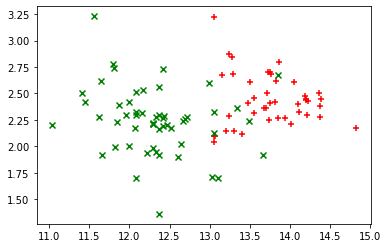

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

There's a fairly obvious area near the center of the plot where a line could divide the two colors of points with a small amount of error.

# Simple Logistic Regression

To implement logistic regression, I need a hypothesis function $h_\theta(x)$, a cost function $J(\theta)$, and a gradient function that computes the partial derivatives of $J(\theta)$.

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between 0 and 1, and produces a value that can be interpreted as a probability.  This value can also be a yes / no answer with a cross-over, or decision boundary, at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [4]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the matrix operations work correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below, and with TensorFlow.  The indexing syntax can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing a gradient descent, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

In [5]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [64.58270054 -4.52048677 -2.23666494]


# Decision Boundaries and Evaluation


I can evaluate the results of the optimization visually and statistically, but I also need one more function: `predict`, which takes an array of examples `X` and learned parameter values `theta` as inputs and returns the predicted label for each.  Here too, 1s must be prepended to the inputs, and I return an integer value representing whether the result of the `sigmoid` hypothesis function is equal to or greater than 0.5.

To test the results of those predictions, Scikit-learn provides three functions to calculate [accuracy, precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).  The test data from earlier is used here, so the results represent the performance of the classifier on unseen data.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9393939393939394
precision: 0.9473684210526316
recall: 0.9375


It's much more interesting to review the results visually, at least while the number of features is limited to two.  To do this, I need to plot the input points again, then overlay the decision boundary on top.  I tried several approaches for this in Matplotlib, and found that an unfilled countour plot gave me the best results.  This can also be done by manually calculating the function to plot, or using a filled contour plot that shades over the actual areas, but doing the math by hand is tedious, and the colormaps for filled contour plots leave a lot to be desired visually.

Below, I define a function `plot_boundary` that takes $n \times 2$ matrix of feature values $(x_0, x_1)$ and a prediction function, then builds a mesh grid of $(x, y)$ points corresponding to possible $(x_0, x_1)$ values within the input range.  After running the prediction function on all of them, the result is an $(x, y, z)$ point in space.  Because the result isn't continuous and flips directly from 0 to 1, there's only one contour that can be drawn on the plot: the decision boundary.

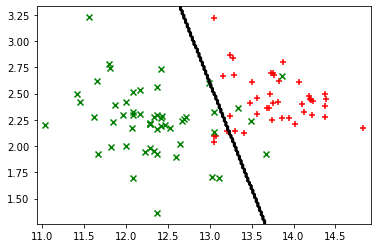

In [7]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

# Multinomial Logistic Regression

With the basics working, the next step is something more interesting: a similar set of two features from the data set (this time alcohol and flavanoids), but with all three labels instead of two.  The only differences below in loading the data are that I no longer filter out rows with the third label, that I use the full output from `label_binarize`, resulting in an $m \times 3$ array for `y`.

C:\Users\TheRealRondon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


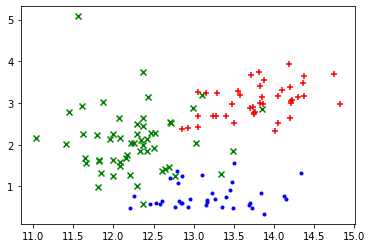

In [8]:
X = data[['alcohol', 'flavanoids']].values
y = data[['class']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = label_binarize(y_train, [1, 2, 3])

plot_points(X_train, y_train.argmax(axis=1))

The plotted data points again suggest some obvious linear boundaries between the wines.

It turns out that solving this as three one-vs-all problems is trivial, and re-uses all the code I just wrote.  Instead of one array of `theta` values I train three, one per problem, and then define a new `predict_multi` function that computes the three sigmoids for each example using each array of `theta` parameters.  This time, rather than return `1` or `0` based on whether the value is above or below 0.5, I return the `argmax` of each resulting row, the index of the largest value.

accuracy: 0.9111111111111111
precision: 0.907051282051282
recall: 0.9109477124183006


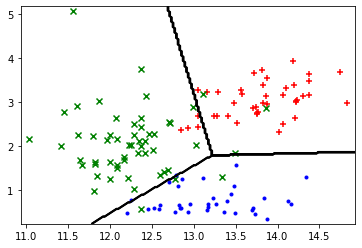

In [9]:
def predict_multi(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(x, thetas))

Looking at the plot above, it seems like the boundaries could be much more accurate if they didn't have to be straight lines.  To allow for this, I define a function `transform` to add some polynomial features, converting each input example of $(x_0, x_1)$ to $(x_0, x_1, x_2, x_3, x_4)$, where $x_2 = x_0^2$, $x_3 = x_1^2$ and $x_4 = x_0x_1$.

accuracy: 0.9555555555555556
precision: 0.9558404558404558
recall: 0.9583333333333334


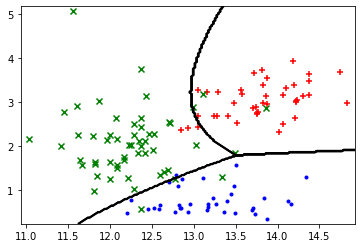

In [10]:
def transform_x(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def transform(X):
    return np.apply_along_axis(transform_x, 1, X)

X_train = transform(X_train)
X_test = transform(X_test)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(transform(x), thetas))